# Ex 1 - GRD Datacube I/O

In this basic example, we will open a stack of Ground Range Detected (GRD) images, read it as a `SARDatacube` object, display the array, run some simple metadata queries, and then save the stack of images as a datacube.

GRD images are georegistered rasters. ICEYE uses the .tif format. This image has only signal intensity and not the complex information.

In [1]:
import os,sys,inspect
import numpy as np
from os.path import dirname, abspath, join
from icecube.bin.sar_cube.grd_datacube import GRDDatacube
from icecube.bin.config import CubeConfig 
import matplotlib.pyplot as plt
from pathlib import Path 
from icecube.bin.datacube_variables import NAME_INTENSITY_BAND

## Creating  a Datacube

Modify the following paths based on your use case. For the purpose of this demo, we'll work on a subset of images used for testing the library.

In [2]:
parent_dir = dirname(dirname(dirname(abspath(inspect.getfile(inspect.currentframe())))))
test_dir =  join(parent_dir, "tests", "resources", "grd_stack")
print(f"The GRDs used for the demo are located at Path_to_library/icecube/tests/resources/grd_stack")

The GRDs used for the demo are located at Path_to_library/icecube/tests/resources/grd_stack


The first step is to create or edit the config file, which is a json file containing the parameters that you want to modify for the datacube construction.

In [3]:
cube_config = CubeConfig()

# If you want to load config parameters;
#cube_config.load_config(cube_config_path)

In [4]:
# build the datacube composed by a stack of GRD
grd_datacube = GRDDatacube.build(cube_config, test_dir)

08/24/2021 04:23:46 PM - sar_datacube_metadata.py - [INFO] - Building the metadata from the folder /home/adupeyrat/Documents/code/icecube/tests/resources/grd_stack using GRD
processing rasters for cubes: 100%|██████████| 3/3 [00:00<00:00, 90.51it/s]
08/24/2021 04:23:46 PM - common_utils.py - [INFO] - create running time is 0.0592 seconds


## `GRDDatacube` object

Every `GRDDatacube` object is a `SARDatacube`

These have multiple methods:

- `.cube_config` -> As seen above, the configuration is the one used to create the datacube. We can modify those parameters by defining a json file that will overload every parameters. 


- `.xrdataset` -> This is theXarray.Dataset containing the stack of images, (Azimuth, Range and Band). Each image is loaded using dask (for memory optimization) and then tranformed into an Xarray.Dataarray. There is one temporal layer in the datacube for each GRD file found in your directory.


- `.get_metadata(temporal_index)` ->  Returns the metadata of the image at the certain index, this is Dict[str, str] representing the images

In [5]:
# You can access the dataset, for an easy visualization. The 'Band' dimension shows the number of GRD images stacked from your input path.
grd_datacube.xrdataset.head

<bound method Dataset.head of <xarray.Dataset>
Dimensions:    (Azimuth: 10, Band: 3, Range: 10)
Coordinates:
  * Azimuth    (Azimuth) int64 0 1 2 3 4 5 6 7 8 9
  * Range      (Range) int64 0 1 2 3 4 5 6 7 8 9
  * Band       (Band) datetime64[ns] 2021-04-27 2021-04-28 2021-05-27
Data variables:
    Intensity  (Band, Azimuth, Range) uint16 329 389 217 418 ... 597 85 482 334>

In [6]:
# Access the array dimensions
grd_datacube.xrdataset.dims

Frozen(SortedKeysDict({'Azimuth': 10, 'Range': 10, 'Band': 3}))

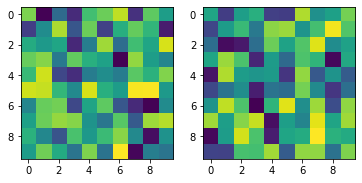

In [7]:
# Let's visualize the intensity component of the grd_datacube for the first and last image of the stack. 
# Will convert the data to bytes (from float64), so we can see something.

fig, ax = plt.subplots(1,2)

#First image in the stack
ax[0].imshow(np.byte(grd_datacube.xrdataset['Intensity'][0].values))

#Last image in the stack
ax[1].imshow(np.byte(grd_datacube.xrdataset['Intensity'][-1].values))

In [8]:
# Slice the stack at the pixel level. If the GRD stack are co-located images at different times, you are slicing by time at this point:
# Let's pick the first pixel in range and aziumuth for all images in the stack. 

#Check the shape of the stack again
print(grd_datacube.xrdataset['Intensity'].shape)

#the stack depth is the first dimension of the array
pixel_time_series = grd_datacube.xrdataset['Intensity'][:,1,1].values
print(f"The time series for the pixel located to the pixel (1,1) is {pixel_time_series}")

(3, 10, 10)
The time series for the pixel located to the pixel (1,1) is [508  81 525]


The raw ICEYE image metadata for each image can be accessed using the method `get_metadata(attributes, datavars, cube_index)`or directly using attrs of the xarray.Dataset[data_vars]


grd_datacube.xrdataset["intensity"].attrs will return a dict[str, list]

- `key` represents the metadata key
- `vlues` represents the values associated with each layer of the datacube - a missing value is represented by `None`

In [9]:
# visualize all possibles values
grd_datacube.xrdataset['Intensity'].attrs.keys()

dict_keys(['spec_version', 'posX', 'grsr_coefficients', 'doppler_rate_poly_order', 'applied_processing', 'gcp_terrain_model', 'incidence_angle_ground_range_origin', 'calibration_factor', 'grsr_zero_doppler_time', 'azimuth_look_overlap', 'grsr_poly_order', 'mean_earth_radius', 'geo_ref_system', 'orbit_repeat_cycle', 'range_looks', 'zerodoppler_end_utc', 'satellite_name', 'incidence_near', 'window_function_range', 'processor_version', 'slant_range_to_first_pixel', 'processing_prf', 'satellite_look_angle', 'heading', 'chirp_bandwidth', 'azimuth_look_bandwidth', 'grsr_ground_range_origin', 'incidence_far', 'product_level', 'azimuth_time_interval', 'number_of_state_vectors', 'acquisition_mode', 'product_file', 'dc_estimate_poly_order', 'chirp_duration', 'dc_estimate_coeffs', 'range_sampling_rate', 'velX', 'polarization', 'azimuth_spacing', 'number_of_dc_estimations', 'processing_time', 'product_name', 'state_vector_time_utc', 'azimuth_looks', 'orbit_absolute_number', 'mean_orbit_altitude', 

In [10]:
# You can see the list of values a specific metadata
grd_datacube.xrdataset['Intensity'].attrs['product_file']

['ICEYE_GRD_54549_20210427T215124_hollow_10x10pixels_fake_1.tif',
 'ICEYE_GRD_54549_20210427T215124_hollow_10x10pixels_fake_0.tif',
 'ICEYE_GRD_54549_20210427T215124_hollow_10x10pixels_fake_2.tif']

In [11]:
# If you know what you are looking for, you can directly use the`get_metadata(attr, var, index)` method
grd_datacube.get_metadata("product_file", 'Intensity', 0)

'ICEYE_GRD_54549_20210427T215124_hollow_10x10pixels_fake_1.tif'

## Build datacube from a list of path

It's also possible to build a datacube from a list of different paths instead of a single local folder. For that, you will need to call the `build_from_list()` function instead of `build()`. The method will build your datacube taking into account only the files in your list. In the following example, we will reduce the inputs to only two images instead of three. Ensure that you are passing only .tif files.

In [12]:
# build the datacube composed of a stack of GRD
list_interesting_paths = [Path(join(test_dir, cur_path)) for cur_path in os.listdir(test_dir)[:2]]
print(list_interesting_paths)

[PosixPath('/home/adupeyrat/Documents/code/icecube/tests/resources/grd_stack/ICEYE_GRD_54549_20210427T215124_hollow_10x10pixels_fake_2.tif'), PosixPath('/home/adupeyrat/Documents/code/icecube/tests/resources/grd_stack/ICEYE_GRD_54549_20210427T215124_hollow_10x10pixels_fake_1.tif')]


In [13]:
# build the datacube composed of a stack of GRD
grd_datacube = GRDDatacube.build_from_list(cube_config, list_interesting_paths)

08/24/2021 04:23:46 PM - sar_datacube_metadata.py - [INFO] - Building the metadata from the list [PosixPath('/home/adupeyrat/Documents/code/icecube/tests/resources/grd_stack/ICEYE_GRD_54549_20210427T215124_hollow_10x10pixels_fake_2.tif'), PosixPath('/home/adupeyrat/Documents/code/icecube/tests/resources/grd_stack/ICEYE_GRD_54549_20210427T215124_hollow_10x10pixels_fake_1.tif')]
processing rasters for cubes: 100%|██████████| 2/2 [00:00<00:00, 165.12it/s]
08/24/2021 04:23:46 PM - common_utils.py - [INFO] - create_from_list running time is 0.0267 seconds


In [14]:
grd_datacube.xrdataset.dims

Frozen(SortedKeysDict({'Azimuth': 10, 'Range': 10, 'Band': 2}))

## Writing a file to GeoTiff

Finally, save the datacube usint the `.to_file()` method of the `SarDatacube` object.
The default format is `netCDF4` - this can be expanded if needed.

In [15]:
grd_datacube.to_file(output_fpath="my_awesome_datacube_grd.nc")

hyvää työtä!